In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from xml.dom import minidom
import re

In [27]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.utils import class_weight

In [3]:
# utworzenie ramki danych
all_files = os.listdir('./ecgen-radiology')

d = {
    'COMPARISON' : [],
    'INDICATION' : [],
    'FINDINGS'   : [],
    'IMPRESSION' : [],
    'CAPTION'    : [],
    'DISEASES'   : []
}

for f in all_files:
    file = minidom.parse('./ecgen-radiology/' + f)
    
    caption = file.getElementsByTagName('caption')
    
    try:
        d['CAPTION'].append(caption[0].childNodes[0].data)
    except IndexError:
        d['CAPTION'].append(None)
    
    models = file.getElementsByTagName('AbstractText')
    
    for i in range(len(models)):
        key = str(models[i].attributes['Label'].value)
        try:
            val = str(models[i].childNodes[0].data)
        except IndexError:
            val = ''
            
        d[key].append(val)
        
        
    dis = file.getElementsByTagName('major')
    dis2 = file.getElementsByTagName('automatic')

    text = ''
    for i in range(len(dis)):
        try:
            text = text + dis[i].childNodes[0].data + ', '
        except IndexError:
            continue

    for i in range(len(dis2)):
        try:
            text = text + dis2[i].childNodes[0].data + ', '
        except IndexError:
            continue

    d['DISEASES'].append(text)
        
for k in d.keys():
    d[k] = np.array(d[k])
    
df = pd.DataFrame(d)
df['DISEASES'] = df['DISEASES'].str[:-2]
df['ILL'] = np.where(df['DISEASES'] == 'normal', 0, 1)

In [31]:
df.head(5)

,COMPARISON,INDICATION,FINDINGS,IMPRESSION,CAPTION,DISEASES,ILL
0,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,Xray Chest PA and Lateral,normal,0
1,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.,PA and lateral chest x-XXXX XXXX.,"Calcified Granuloma/lung/upper lobe/right, cal...",1
2,None.,NaN,Both lungs are clear and expanded. Heart and m...,No active disease.,"CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX PM",normal,0
3,XXXX PA and lateral chest radiographs,"XXXX-year-old male, XXXX.",There is XXXX increased opacity within the rig...,1. Increased opacity in the right upper lobe w...,PA and lateral chest x-XXXX XXXX.,"Opacity/lung/upper lobe/right, Pulmonary Atele...",1
4,None,"dyspnea, subjective fevers, arthritis, immigra...",Interstitial markings are diffusely prominent ...,Diffuse fibrosis. No visible focal acute disease.,"CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX PM",Markings/lung/bilateral/interstitial/diffuse/p...,1


In [32]:
def clean(data):
    for c in data.columns:
        data[c] = data[c].apply(lambda x : x.lower())
        data[c] = data[c].apply(lambda x : re.sub(r'[^A-Za-z ]+', ' ', x))
        data[c] = data[c].apply(lambda x : re.sub(r'[A-Za-z]*xxxx[A-Za-z]*', '', x))
    
    return data

df = df.fillna('')

df2 = df[['FINDINGS', 'ILL']]
df2['FINDINGS'] = clean(df2[['FINDINGS']])
df2.head()

C:\Users\z6pyo\AppData\Local\Temp\ipykernel_11388\3718820318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[c] = data[c].apply(lambda x : x.lower())
C:\Users\z6pyo\AppData\Local\Temp\ipykernel_11388\3718820318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[c] = data[c].apply(lambda x : re.sub(r'[^A-Za-z ]+', ' ', x))
C:\Users\z6pyo\AppData\Local\Temp\ipykernel_11388\3718820318.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,FINDINGS,ILL
0,the cardiac silhouette and mediastinum size ar...,0
1,the cardiomediastinal silhouette is within nor...,1
2,both lungs are clear and expanded heart and m...,0
3,there is increased opacity within the right u...,1
4,interstitial markings are diffusely prominent ...,1


In [33]:
df2['ILL'].value_counts()

1    2564
0    1391
Name: ILL, dtype: int64

Będziemy wykonywać klasyfikację binarną na podstawie kolumny ILL stwierdzającej, czy pacjent jest chory czy zdrowy. Uczymy za pomocą kolumn FINDINGS lub IMPRESSION. Widać dysproporcję między klasami.

Na podstawie:
https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/47_BERT_text_classification/BERT_email_classification-handle-imbalance.ipynb

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df2['FINDINGS'],df2['ILL'],
                                                    stratify=df2['ILL'])

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)

In [37]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")


In [38]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)



<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843517  , -0.51327264, -0.8884572 , ..., -0.74748856,
        -0.75314724,  0.91964495],
       [-0.8720835 , -0.50543964, -0.94446677, ..., -0.85847515,
        -0.71745354,  0.8808298 ]], dtype=float32)>

In [62]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(10, activation='sigmoid', name="middle1")(l)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [63]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [64]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [46]:
class_weights = {
    0: 1.42186002,
    1: 0.77119085
}

In [65]:
model.fit(X_train, y_train, epochs=10, class_weight=class_weights)

Epoch 1/10
93/93 [==============================] - 340s 4s/step - loss: 0.6335 - accuracy: 0.6150 - precision: 0.7748 - recall: 0.5725
Epoch 2/10
93/93 [==============================] - 343s 4s/step - loss: 0.5904 - accuracy: 0.6777 - precision: 0.7972 - recall: 0.6745
Epoch 3/10
93/93 [==============================] - 340s 4s/step - loss: 0.5869 - accuracy: 0.6777 - precision: 0.7925 - recall: 0.6812
Epoch 4/10
93/93 [==============================] - 336s 4s/step - loss: 0.5774 - accuracy: 0.6989 - precision: 0.7956 - recall: 0.7207
Epoch 5/10
93/93 [==============================] - 335s 4s/step - loss: 0.5724 - accuracy: 0.6888 - precision: 0.8060 - recall: 0.6849
Epoch 6/10
93/93 [==============================] - 333s 4s/step - loss: 0.5600 - accuracy: 0.7053 - precision: 0.8154 - recall: 0.7051
Epoch 7/10
93/93 [==============================] - 334s 4s/step - loss: 0.5595 - accuracy: 0.7003 - precision: 0.8052 - recall: 0.7093
Epoch 8/10
93/93 [==============================

In [66]:
model.evaluate(X_test, y_test)

31/31 [==============================] - 113s 4s/step - loss: 0.5138 - accuracy: 0.7573 - precision: 0.7868 - recall: 0.8580


[0.5138124823570251,
 0.7573306560516357,
 0.7868383526802063,
 0.8580343127250671]

# Wyniki na zbiorze testowym

#### Accuracy - 0.7573 
#### Precision - 0.7868 
#### Recall - 0.8580

In [67]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

31/31 [==============================] - 112s 4s/step


In [68]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,

In [69]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[199, 149],
       [ 91, 550]], dtype=int64)

Text(33.0, 0.5, 'Truth')

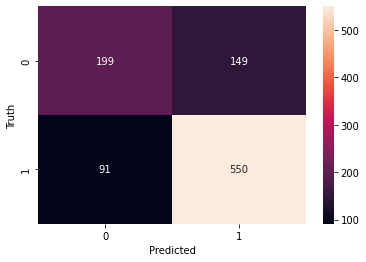

In [70]:
from matplotlib import pyplot as plt
import seaborn as sn
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

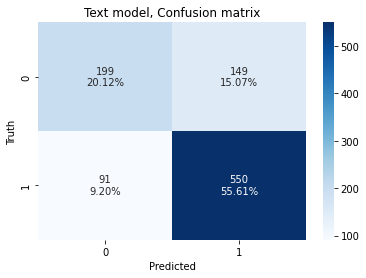

In [71]:

cf_matrix = confusion_matrix(y_test, y_predicted)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Text model, Confusion matrix')
plt.savefig('plot.png')

In [ ]:
model.save('my_model')

Test wczytywania modelu:

In [ ]:
new_model = tf.keras.models.load_model('my_model')
new_model.summary()